In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, TimeDistributed, BatchNormalization
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42
lr = 0.0001
batch = 64

Get my own dataset

In [4]:
X_train, y_train, X_test, y_test, X_val, y_val, vocab_size, emdedding_size, vectors = get_data()

In [5]:
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))
print('Val labels: ', collections.Counter(y_val))

Train labels:  Counter({1: 3021, 0: 3020})
Test labels:  Counter({0: 863, 1: 863})
Val labels:  Counter({0: 432, 1: 431})


In [6]:
train_max = X_train.max()
test_max = X_test.max()
val_max = X_val.max()
max_all = max([train_max, test_max, val_max])
input_dim = max_all+1
output_dim = 32

In [7]:
# Concatinate train and validation to be used in cross validation
Xtrain_concat = np.concatenate((X_train,X_val),axis=0)
ytrain_concat = np.concatenate((y_train,y_val),axis=0)

In [8]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [10]:
adamOptimizer = Adam(lr=lr)

In [11]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title, modelname):
    pp = PdfPages(modelname)
    plt.figure()
    history = history_arrs[0]
    plt.plot(history[train])
    plt.plot(history[val])
    plt.title(plot_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(['Train', 'Validation'], loc='upper left')
    pp.savefig()
    plt.show()
    pp.close()

In [12]:
def model_1(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

In [13]:
def run_test(model_func, Xtrain, ytrain, embedding_layer):
    results = []
    best_acc = 0
    for i,(train_index, val_index)in enumerate(sk.split(Xtrain, ytrain)):
        if embedding_layer == 'nowv':
            el = Embedding(input_dim, output_dim, trainable = True)
        elif embedding_layer == 'wv':
            el = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(el)
        history = model.fit(Xt, yt, epochs=15, batch_size=batch, verbose = 0)
        loss, acc = model.evaluate(Xv, yv, verbose=0, batch_size=batch)
        print('Accuracy for iteration %d: %.4f' % (i, acc))
        results.append(acc)
    results = np.array(results)
    return results

In [14]:
def calculate_metrics(model, X_test, y_test):
    ypred_class = model.predict_classes(X_test, verbose=0)
    ypred_class = ypred_class[:, 0]
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)
    return accuracy, precision, recall, f1, conf_matrix

In [15]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix, 
    index=['true:positive', 'true:negative'], 
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

# Model 1

First model cross-validation without pretrained word vectors

In [16]:
results = run_test(model_1, Xtrain_concat, ytrain_concat, 'nowv')
print('Average model 1 accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model 1 accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8610
Accuracy for iteration 1: 0.8683
Accuracy for iteration 2: 0.8622
Average model 1 accuracy of cross validation without word vectors: 0.8638
Standard deviation of the accuracy: 0.0032
The best model 1 accuracy of cross validation without word vectors: 0.8683


First model evaluation without pretrained word vectors

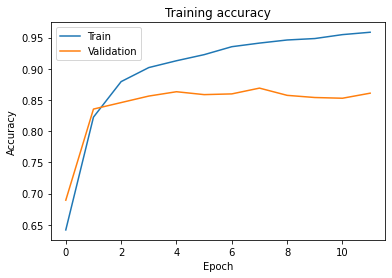

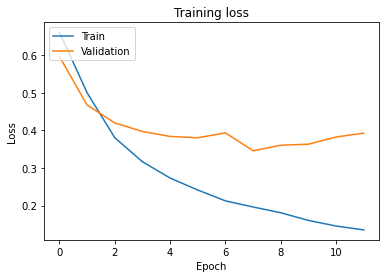

Model statistics with class predictions: 
Accuracy: 0.8714
Precision: 0.8581
Recall: 0.8899
F1 score: 0.8737
Confusion matrix:
               pred:positive  pred:negative
true:positive            736            127
true:negative             95            768


In [17]:
embedding_layer = Embedding(input_dim, output_dim, trainable = True)
model = model_1(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'lstm1-nowv-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'lstm1-nowv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [18]:
# Save the model (weights, architecture)
model.save('../../models/models/lstm-nowv')

INFO:tensorflow:Assets written to: ../../models/models/lstm-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm-nowv\assets


First model cross-validation with pretrained word vectors

In [19]:
results = run_test(model_1, Xtrain_concat, ytrain_concat, 'wv')
print('Average model 1 accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model 1 accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8879
Accuracy for iteration 1: 0.8635
Accuracy for iteration 2: 0.8683
Average model 1 accuracy of cross validation without word vectors: 0.8733
Standard deviation of the accuracy: 0.0106
The best model 1 accuracy of cross validation without word vectors: 0.8879


First model evaluation with pretrained word vectors

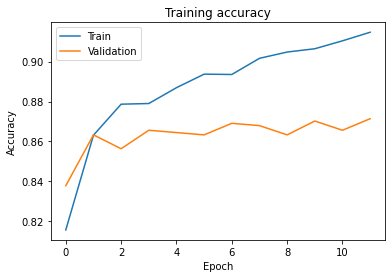

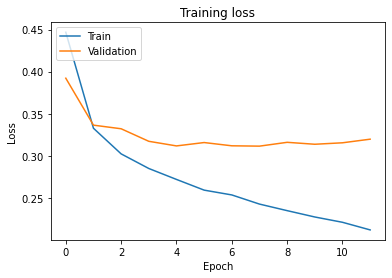

Model statistics with class predictions: 
Accuracy: 0.8824
Precision: 0.8750
Recall: 0.8922
F1 score: 0.8835
Confusion matrix:
               pred:positive  pred:negative
true:positive            753            110
true:negative             93            770


In [20]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
model = model_1(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'lstm1-wv-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'lstm1-wv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [21]:
# Save the model (weights, architecture)
model.save('../../models/models/lstm-wv')

INFO:tensorflow:Assets written to: ../../models/models/lstm-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm-wv\assets


# Model 2

In [22]:
def model_2(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Second model cross-validation without pretrained word vectors

In [23]:
results = run_test(model_2, Xtrain_concat, ytrain_concat, 'nowv')
print('Average model 2 accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model 2 accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8662
Accuracy for iteration 1: 0.8696
Accuracy for iteration 2: 0.8644
Average model 2 accuracy of cross validation without word vectors: 0.8667
Standard deviation of the accuracy: 0.0022
The best model 2 accuracy of cross validation without word vectors: 0.8696


Second model evaluation without pretrained word vectors

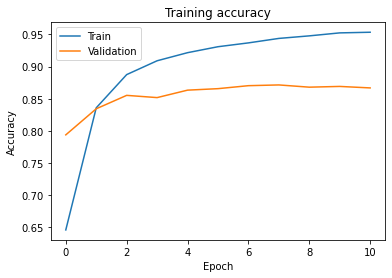

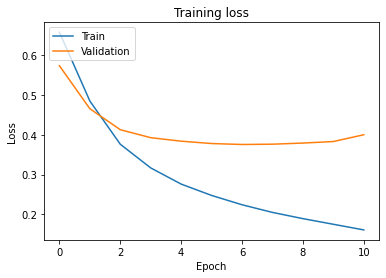

Model statistics with class predictions: 
Accuracy: 0.8743
Precision: 0.8873
Recall: 0.8575
F1 score: 0.8721
Confusion matrix:
               pred:positive  pred:negative
true:positive            769             94
true:negative            123            740


In [24]:
embedding_layer = Embedding(input_dim, output_dim, trainable = True)
model = model_1(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'lstm2-nowv-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'lstm2-nowv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [25]:
# Save best performing model (weights, architecture)
model.save('../../models/models/lstm2-nowv')

INFO:tensorflow:Assets written to: ../../models/models/lstm2-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm2-nowv\assets


Second model cross-validation with pretrained word vectors

In [26]:
results = run_test(model_2, Xtrain_concat, ytrain_concat, 'wv')
print('Average model 2 accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model 2 accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8858
Accuracy for iteration 1: 0.8627
Accuracy for iteration 2: 0.8757
Average model 2 accuracy of cross validation without word vectors: 0.8747
Standard deviation of the accuracy: 0.0095
The best model 2 accuracy of cross validation without word vectors: 0.8858


Second model evaluation with pretrained word vectors

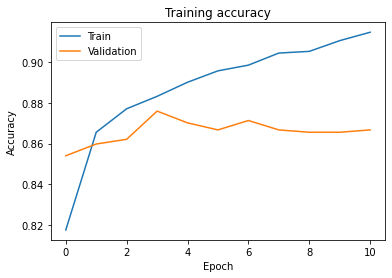

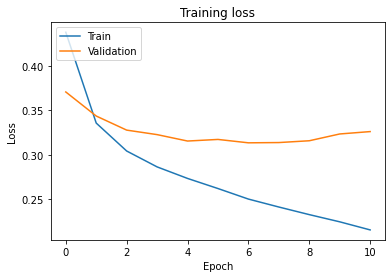

Model statistics with class predictions: 
Accuracy: 0.8864
Precision: 0.8882
Recall: 0.8841
F1 score: 0.8862
Confusion matrix:
               pred:positive  pred:negative
true:positive            767             96
true:negative            100            763


In [27]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
model = model_1(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'lstm2-wv-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'lstm2-wv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [28]:
model.save('../../models/models/lstm2-wv')

INFO:tensorflow:Assets written to: ../../models/models/lstm2-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm2-wv\assets


# Model architecture tests on IMDB dataset

In [29]:
# IMDB dataset
from keras.datasets import imdb

In [30]:
word_count = 5000
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)

## Model 1

First model evaluation

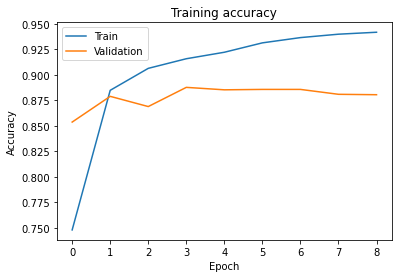

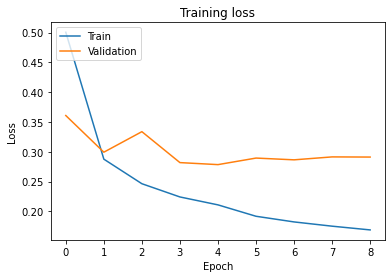

Model statistics with class predictions: 
Accuracy: 0.8768
Precision: 0.8674
Recall: 0.8896
F1 score: 0.8784
Confusion matrix:
               pred:positive  pred:negative
true:positive          10800           1700
true:negative           1380          11120


In [31]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_1(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'imdb_lstm1-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'imdb_lstm1-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation

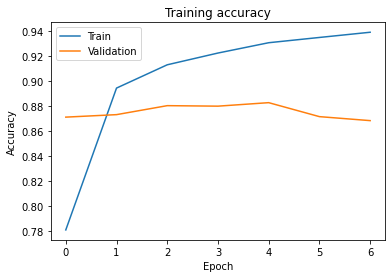

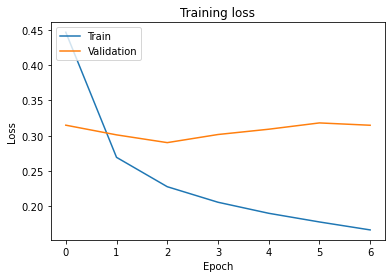

Model 2 statistics with class predictions: 
Accuracy: 0.8706
Precision: 0.8836
Recall: 0.8536
F1 score: 0.8683
Confusion matrix:
               pred:positive  pred:negative
true:positive          11094           1406
true:negative           1830          10670


In [32]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_2(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'imdb_lstm2-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'imdb_lstm2-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model 2 statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)